In [2]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from pythonds.basic.stack import Stack
from math import *
from sklearn.neighbors import KDTree
from lrg_plot_functions import *
from lrg_sum_functions import *
from cosmo_Calc import *
from divideByTwo import *
from read_data import *
from nearNeighbors import *
from scipy import stats
from astropy import stats
import healpy as hp
from localBKG_and_interlopersHEALPix import *
# import healpy as hpy
from makeCutoutTableFunc import *
from plotHistogramProjections3D import *
from read_bricks import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random

In [9]:
ra_dat2 = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/ra_BKG-EDR.npz')
ra_BKG2 = ra_dat2['arr_0']
print(len(ra_BKG2))
print('ra done')

dec_dat2 = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/dec_BKG-EDR.npz')
dec_BKG2 = dec_dat2['arr_0']
print(len(dec_BKG2))
print('dec done')

galdepth_z_dat2 = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/galdepth_z_BKG-EDR.npz')
galdepth_z_BKG2 = galdepth_z_dat2['arr_0']
print(len(galdepth_z_BKG2))
print('galdepth done')

# trans_g_dat2 = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/trans_g_BKG-bin2.npz')
# trans_g_BKG2 = trans_g_dat2['mw_trans_g_BKG_bin2']
# print(len(trans_g_BKG2))
# print('trans g done')

# trans_r_dat2 = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/trans_r_BKG-bin2.npz')
# trans_r_BKG2 = trans_r_dat2['mw_trans_r_BKG_bin2']
# print(len(trans_r_BKG2))
# print('trans r done')

# trans_z_dat2 = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/trans_z_BKG-bin2.npz')
# trans_z_BKG2 = trans_z_dat2['mw_trans_z_BKG_bin2']
# print(len(trans_z_BKG2))
# print('trans z done')

4241001
ra done
4241001
dec done
4241001
galdepth done


In [49]:
ra_BKG = ra_BKG2[np.where((ra_BKG2 >= 241) & (ra_BKG2 <= 246) & (dec_BKG2 >= 6.5) & (dec_BKG2 <= 11.5) & (galdepth_z_BKG2 != 0.))]
print(len(ra_BKG))

dec_BKG = dec_BKG2[np.where((ra_BKG2 >= 241) & (ra_BKG2 <= 246) & (dec_BKG2 >= 6.5) & (dec_BKG2 <= 11.5) & (galdepth_z_BKG2 != 0.))]
print(len(dec_BKG))

galdepth_z_BKG = galdepth_z_BKG2[np.where((ra_BKG2 >= 241) & (ra_BKG2 <= 246) & (dec_BKG2 >= 6.5) & (dec_BKG2 <= 11.5) & (galdepth_z_BKG2 != 0.))]
print(len(galdepth_z_BKG))

print(ra_BKG.min())
print(ra_BKG.max())
print(dec_BKG.min())
print(dec_BKG.max())


1078290
1078290
1078290
241.0000052274216
245.99999742510235
6.50000577188726
11.499987383828802


In [50]:
# Make HEALPix map using just RA/Dec; end up with a density plot

nside = 1024
npixel = hp.nside2npix(nside)

# ra_cut = ra[np.where(zmag <= 21.5)]
# dec_cut = dec[np.where(zmag <= 21.5)]

# Convert ra/dec into theta/phi
theta = []
phi = []

for i in range(len(ra_BKG)):
    theta.append(np.radians(90. - dec_BKG[i]))
    phi.append(np.radians(ra_BKG[i]))

print('length phi: ', len(phi))
# Convert angles theta and phi to pixel numbers
pixnums = hp.ang2pix(nside, theta, phi, nest=True)
print('pixnums: ', pixnums)
print(pixnums[0])
print('length pixnums: ', len(pixnums))


# Create a HEALPix map from pix
mapp = np.bincount(pixnums, minlength=npixel)
# print('map where ne 0: ', mapp[np.where(mapp > 0)])
# print('length map == 0: ', len(mapp[np.where(mapp == 0)]))
# print('length map: ', len(mapp))

# masked_map = np.zeros(len(mapp))
# masked_map[(mapp == 0)] = 1

# m = hp.ma(mapp)
# m.mask = masked_map



length phi:  1078290
pixnums:  [8076271 8098137 8098117 ... 8099720 8099721 8099720]
8076271
length pixnums:  1078290


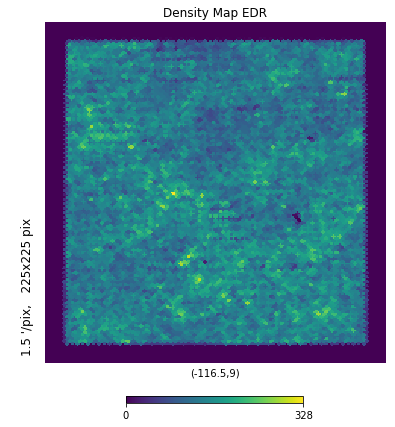

In [51]:
# Plot mapp
hp.gnomview(mapp, xsize=225, rot=(-116.5, 9), flip='astro', nest=True, title='Density Map EDR')
# hp.gnomview(mapp, flip='astro', xsize=1800, rot=(75., 163.), nest=True, title='BIN2')
# plt.savefig('/Users/mtownsend/Desktop/HEALPix-bin2.pdf')
plt.show()

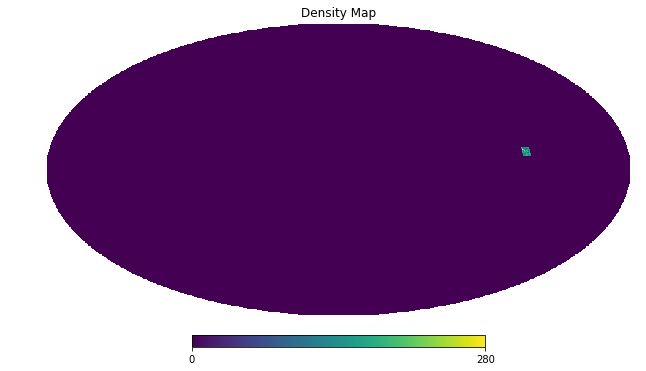

In [52]:
hp.mollview(mapp, flip='astro', nest=True, title='Density Map')
plt.show()

In [53]:
# for a 5 sigma detection limit

# flux in nanomaggies
zflux_nanomaggies_5 = 5.*(np.sqrt(galdepth_z_BKG))
print(galdepth_z_BKG.min())

# AB magnitudes
zmag_AB = -2.5*(np.log10(zflux_nanomaggies_5) - 9.)

5.426292


In [71]:
# This section maps various values of the galaxies into a HEALPix map so the result is basically a density map of
# galaxy properties. In this code the new maps are array_g, array_r, and array_z.

# returns indices that would sort the array pixnums
pixorder = np.argsort(pixnums)
# returns sorted unique values of pixnums, indices to reconstruct the original array from the unique array,
# and the number of times each unique value comes up in the original array
pixels, pixinverse, pixcnts = np.unique(pixnums, return_inverse=True, return_counts=True)

# print(len(pixnums))
# print('----')
# print(pixorder)
# print('----')
# print(len(pixels))
# print('----')
# print(pixcnts)
# inserts a zero in the zeroth index space, moving all other values down the line
pixcnts = np.insert(pixcnts, 0, 0)
# calculates the cumulative sum of the values in pixcnts
pixcnts = np.cumsum(pixcnts)
# print(pixcnts)

# This seems like a weird thing to do, but this is why: pixnums is an array of pixel numbers that correspond to a
# galaxy. There are many galaxies per pixel, so the individual pixnum will repeat. pixcnts is the number of times
# each unique value appears in pixnums. pixorder is the array of indices that would sort pixnums. The loop below makes
# a map of median values per pixel for any desired characteristic. In the loop, inds is the index array of galaxies
# that show up in a pixel (the pixnum values). It uses the range set by pixcnts to determine which index from
# pixorder is used. In the loop, pix is the pixel number inds belongs in.

array_g = np.full(npixel, -1.)
array_r = np.full(npixel, -1.)
array_z = np.full(npixel, -1.)
pix = []
for i in range(len(pixcnts)-1):
# for i in range(1):
    inds = pixorder[pixcnts[i]:pixcnts[i+1]]
#     print(inds)
    pix = pixnums[inds][0]
#     print(pix)
#     array_g[pix] = np.median(trans_g_BKG2[inds])
#     array_r[pix] = np.median(trans_r_BKG2[inds])
    array_z[pix] = np.median(zmag_AB[inds])
    # array_g[pix] = -2.5*(np.log10(5. / np.sqrt(np.median(galdepth_g[inds]))) - 9.)
    # array_r[pix] = -2.5*(np.log10(5. / np.sqrt(np.median(galdepth_r[inds]))) - 9.)
    # array_z[pix] = -2.5*(np.log10(5. / np.sqrt(np.median(galdepth_z[inds]))) - 9.)

# print(array_g[array_g != -1])
# print(array_r[array_r != -1])
# print(array_z[array_z != -1])

# masked_map_g = np.zeros(len(array_g))
# masked_map_g[(array_g == -1.)] = 1

# mg = hp.ma(array_g)
# mg.mask = masked_map_g

# masked_map_r = np.zeros(len(array_r))
# masked_map_r[(array_r == -1.)] = 1

# mr = hp.ma(array_r)
# mr.mask = masked_map_r

masked_map_z = np.zeros(len(array_z))
masked_map_z[(array_z == -1.)] = 1

mz = hp.ma(array_z)
mz.mask = masked_map_z

# # hp.gnomview(mg, xsize=225, ysize=225, rot=(-116.5, 9.), flip='geo', nest=True, title='Median gmag (nobs >= 2)')
# # plt.show()
# #
# # hp.gnomview(mr, xsize=225, ysize=225, rot=(-116.5, 9.), flip='geo', nest=True, title='Median rmag (nobs >= 2)')
# # plt.show()

# This HEALPix image shows the median zmag in each pixel

# hp.gnomview(mz, xsize=225, rot=(-116.5, 9), flip='astro', nest=True, title='Median galdepth in z (EDR)')
# # hp.gnomview(mapp, flip='astro', xsize=1800, rot=(75., 163.), nest=True, title='BIN2')
# plt.savefig('/Users/mtownsend/Desktop/HEALPix-median-galdepth-z-EDR.pdf')
# plt.show()

# hp.gnomview(mz, flip='astro', xsize=1800, min=20., rot=(75., 163.), nest=True, title='BIN2-Median zmag')
# # plt.savefig('/Users/mtownsend/Desktop/HEALPix-median-zmag-bin2.pdf')
# plt.show()

# hp.gnomview(mr, flip='astro', xsize=1800, rot=(75., 163.), nest=True, title='BIN2-Median r transmission')
# plt.savefig('/Users/mtownsend/Desktop/HEALPix-median-r-trans-bin2.pdf')
# plt.show()

# hp.gnomview(mz, flip='astro', xsize=1800, rot=(75., 163.), nest=True, title='BIN2-Median z transmission')
# plt.savefig('/Users/mtownsend/Desktop/HEALPix-median-z-trans-bin2.pdf')
# plt.show()

# hp.gnomview(mg, flip='astro', xsize=1800, max=0.8, rot=(75., 163.), nest=True, title='BIN2-Median g transmission (80%)')
# plt.savefig('/Users/mtownsend/Desktop/HEALPix-median-g-trans-80-bin2.pdf')
# plt.show()

# hp.gnomview(mr, flip='astro', xsize=1800, max=0.8, rot=(75., 163.), nest=True, title='BIN2-Median r transmission (80%)')
# plt.savefig('/Users/mtownsend/Desktop/HEALPix-median-r-trans-80-bin2.pdf')
# plt.show()

# hp.gnomview(mz, flip='astro', xsize=1800, max=0.8, rot=(75., 163.), nest=True, title='BIN2-Median z transmission (80%)')
# plt.savefig('/Users/mtownsend/Desktop/HEALPix-median-z-trans-80-bin2.pdf')
# plt.show()



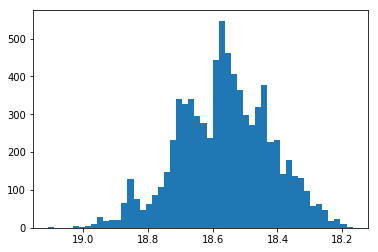

12582912
7736
-1.0
19.1057071685791


In [75]:
plt.hist(array_z[np.where(array_z > -1.)], bins=50)
plt.gca().invert_xaxis()
# plt.axvline(x=cutlen_z2, linewidth=1, color='black')
plt.show()

print(len(array_z))
print(len(array_z[np.where(array_z > -1.)]))

print(array_z.min())
print(array_z.max())


percentile:  18.73723316192627


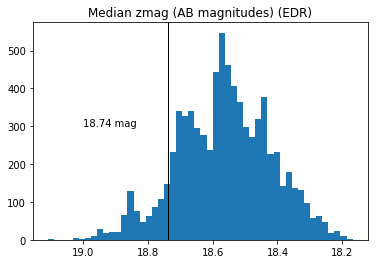

In [80]:
# This section isolates the top 98 percent brightest sources in zmag. array_z is a map of median values for zmag for
# each HEALPix pixel.

# sort zmag array
# sort_zmag = np.sort(zmag_BKG2)
sort_zmagAB = np.sort(array_z[np.where(array_z > -1.)])
# find 90th percentile value
cutlen_z2 = np.percentile(sort_zmagAB, 90)
print('percentile: ', cutlen_z2)

plt.hist(array_z[np.where(array_z > -1.)], bins=50)
plt.gca().invert_xaxis()
plt.axvline(x=cutlen_z2, linewidth=1, color='black')
plt.text(19, 300, '{} mag'.format(round(cutlen_z2,2), fontsize=12))
plt.title("Median zmag (AB magnitudes) (EDR)")
plt.savefig("/Users/mtownsend/Desktop/median-zmag-EDR.pdf")
plt.show()


# ra90 = ra_BKG2[np.where(zmag_BKG2 <= cutlen_z2)]
# dec90 = dec_BKG2[np.where(zmag_BKG2 <= cutlen_z2)]

# phi98 = []
# theta98 = []

# for i in range(len(ra90)):
#     theta98.append(np.radians(90. - dec90[i]))
#     phi98.append(np.radians(ra90[i]))

# # Convert angles theta and phi to pixel numbers
# pixnums98 = hp.ang2pix(nside, theta98, phi98, nest=True)

# # Create a HEALPix map from pix
# density_map98 = np.bincount(pixnums98, minlength=npixel)

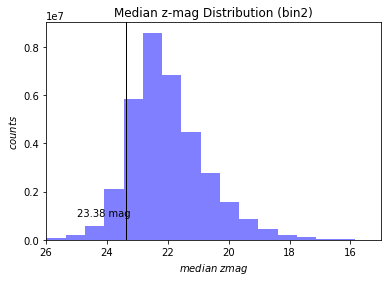

In [24]:
# Plot mapp
# hp.gnomview(density_map98, flip='astro', xsize=1800, rot=(75., 163.), nest=True, title='BIN2; zmag<23.37')
# plt.savefig("/Users/mtownsend/Desktop/zmag_cut_bin2.pdf")
# plt.show()

plt.title("Median z-mag Distribution (bin2)")
plt.hist(zmag_BKG2, bins=50, color='blue', alpha=0.5)
plt.xlabel(r'$median$ $zmag$')
plt.ylabel(r'$counts$')
plt.xlim(15., 26.)
plt.gca().invert_xaxis()
plt.axvline(x=cutlen_z2, linewidth=1, color='black')
plt.text(25,1000000, '{} mag'.format(round(cutlen_z2,2), fontsize=12))
plt.savefig("/Users/mtownsend/Desktop/zmag_cut_bin2.pdf")
plt.show()

# plt.title("zmag Distribution for LRGs")
# plt.hist(zmag_LRG, bins=50, color='blue', alpha=0.5)
# plt.xlabel(r'$zmag$')
# plt.ylabel(r'$counts$')
# # plt.xlim(19., 24.)
# plt.gca().invert_xaxis()
# # plt.axvline(x=reverse_sorted_z[np.int64(nz1)], linewidth=1, color='black')
# # plt.text(22.4, 450, '{} mag'.format(np.around(reverse_sorted_z[np.int64(nz1)], decimals=2)), fontsize=8)
# # plt.savefig("/Users/mtownsend/Desktop/zmag_cut.pdf")
# plt.show()